# Assignment 2
- # Choose the significance threshold
- # Clearly state they Null and Alternate hypothesis
- # Wrangle the data so that it is ready for your analysis.

In [3]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

#if os.getenv ('PUI2018') is None
#    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

#import os
import json
#s = json.load(open(os.getenv('PUI2018') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


# IDEA:
## Subscribers are more likely to bike than customers _for commuting_

# NULL HYPOTHESIS:
## Subscribers bike on weekends is _the same_ or _higher_  than the proportion of customers biking on weekends

# _$H_0$_ : $\frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}} <= \frac{C_{\mathrm{weekend}}}{C_{\mathrm{total}}}$
# _$H_1$_ : $\frac{S_{\mathrm{weekend}}}{S_{\mathrm{total}}} > \frac{C_{\mathrm{total}}}{C_{\mathrm{total}}}$

## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

## I am starting with a single month of data:  reading data from citibike csv file from June 2014

what I want is the date and time of the beginning of each trip. pandas has an easy method to read csv files, and an easy method to convert strinds to dates.

if i read a csv file with pandas the content is stored in a "DataFrame". You can think of it as a python dictionary in many ways,but it has many added capabilities: it is easy to convert variables within it, it knows how to plot itself, etc.

### download and move  data to PUIDATA
# NOTE: 
# 1. access to data from within the notebook _is required_
# 2. if data is downloaded it _must_ be stored in a directory pointed to by the environmental variable PUIDATA

In [4]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")
print("PUIdata", os.getenv("PUIdata"))
!ls $PUIDATA

PUIdata None
201402-citibike-tripdata.csv	chisq2.png
201402-citibike-tripdata.zip	dhsdaily.csv
201406-citibike-tripdata.csv	dhsdailyy.json
201406-citibike-tripdata.zip	get_bus_info_mv1742.ipynb
Assignment1[1].ipynb		PUI2018_mv1742
Assignment1_mv1742-Copy1.ipynb	Screen_Shot_2018-09-26_at_1.14.09_PM[1].png
Assignment2_mv1742.ipynb	show_bus_locations_mv1742.ipynb
chisq1.png			times.txt


In [5]:
os.getenv("PUIDATA")

'/nfshome/mv1742/PUIDATA'

In [6]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

In [7]:
#https://s3.amazonaws.com/tripdata/201402-citibike-tripdata.zip
datestring = '201406'
getCitiBikeCSV(datestring)

file in place, you can continue


In [8]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys.
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

tripduration            starttime             stoptime  start station id  \
0           520  2014-06-01 00:00:02  2014-06-01 00:08:42               358   
1           520  2014-06-01 00:00:27  2014-06-01 00:09:07               335   
2           414  2014-06-01 00:00:32  2014-06-01 00:07:26               439   
3           310  2014-06-01 00:00:34  2014-06-01 00:05:44               463   
4           457  2014-06-01 00:00:35  2014-06-01 00:08:12               352   

              start station name  start station latitude  \
0  Christopher St & Greenwich St               40.732916   
1       Washington Pl & Broadway               40.729039   
2                 E 4 St & 2 Ave               40.726281   
3                9 Ave & W 16 St               40.742065   
4                W 56 St & 6 Ave               40.763406   

   start station longitude  end station id          end station name  \
0               -74.007114             426     West St & Chambers St   
1               -73.994046             265  Stanton St & Chrystie St   
2               -73.989780             368        Carmine St & 6 Ave   
3               -74.004432             380          W 4 St & 7 Ave S   
4               -73.977225             305           E 58 St & 3 Ave   

   end station latitude  end station longitude  bikeid    usertype birth year  \
0             40.717548             -74.013221   18840  Subscriber       1979   
1             40.722293             -73.991475   17442    Customer         \N   
2             40.730386             -74.002150   16447  Subscriber       1980   
3             40.734011             -74.002939   18218  Subscriber       1984   
4             40.760958             -73.967245   18115  Subscriber       1969   

   gender                date  
0       1 2014-06-01 00:00:02  
1       0 2014-06-01 00:00:27  
2       1 2014-06-01 00:00:32  
3       1 2014-06-01 00:00:34  
4       1 2014-06-01 00:00:35

In [9]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

In [10]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid','gender',
       'birth year'], axis=1, inplace=True)

In [11]:
df.head()

usertype                date
0  Subscriber 2014-06-01 00:00:02
1    Customer 2014-06-01 00:00:27
2  Subscriber 2014-06-01 00:00:32
3  Subscriber 2014-06-01 00:00:34
4  Subscriber 2014-06-01 00:00:35

### Lets separate subscribers (_s) from customers (_w) to test the hypotheses.

### Lets plot the number of trips per week day

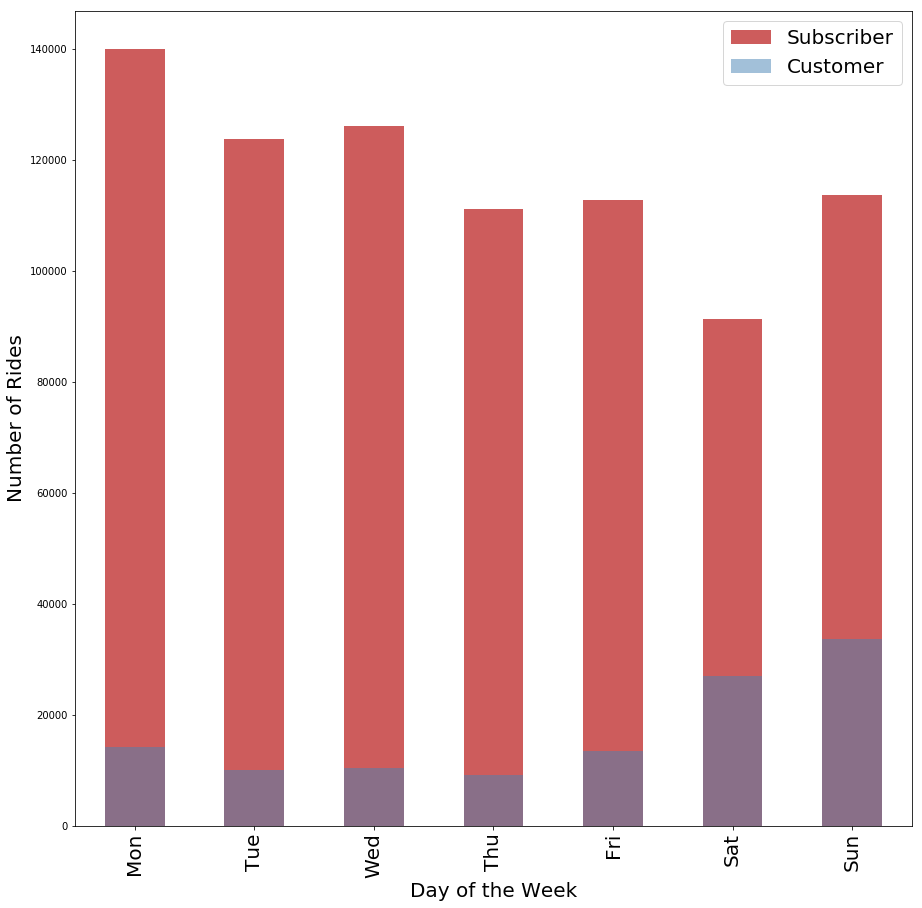

In [12]:
ig  =  pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_c = 1
((df['date'][df['usertype'] == 'Subscriber'].groupby([df['date'].dt.weekday]).count()) / norm_c).plot(kind="bar", color='IndianRed', 
label='Subscriber')

norm_s = 1
ax = ((df['date'][df['usertype'] =='Customer'].groupby([df['date'].dt.weekday]).count()) / norm_s).plot(kind="bar", color='SteelBlue', alpha=0.5,label='Customer')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_xlabel("Day of the Week", fontsize=20)
ax.set_ylabel("Number of Rides", fontsize=20)
pl.legend(['Subscriber','Customer'],fontsize=20)

## Figure 1a: Distribution of Citibike bikers by usertype in June 2014, absolute counts

### Note: the counts have errors of course. what is the error on the count statistics? 
### for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

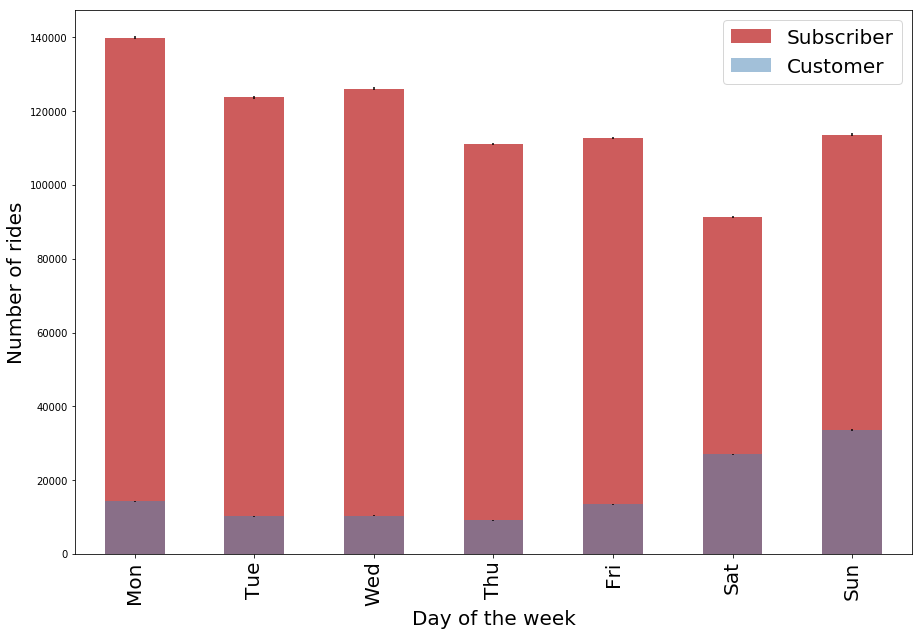

In [13]:
ig=pl.figure(figsize(15,10))

counts_c = df.date[df.usertype == 'Subscriber'].groupby([df.date.dt.weekday]).count()
norm_c = 1
error_c = np.sqrt(counts_c)
ax=((counts_c) / norm_c).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_c) / norm_c, (error_c) / norm_c)], label='Subscriber')


counts_s = df.date[df.usertype == 'Customer'].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s=np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", alpha=0.5, yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           color='SteelBlue', label='Customer')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides",fontsize=20)
ax.set_xlabel ("Day of the week",fontsize=20)
pl.legend(['Subscriber','Customer'],fontsize=20)

## Figure 1b: Distribution of Citibike bikers by usertype in June 2014, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of man, and that of women, i.e. devide them by the total number of rides for that gender. 
(Notice that i have to normalize the errorbars too!)



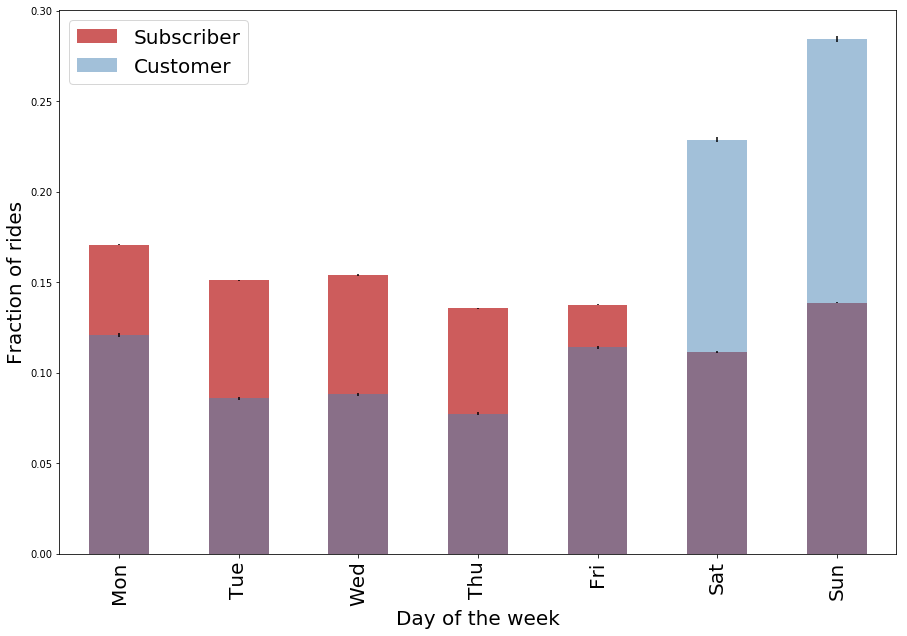

In [14]:
fig = pl.figure(figsize(15,10))

norm_c = counts_c.sum()
error_c = np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_c) / norm_c, (error_c) / norm_c)], 
                           label='Subscriber')

norm_s = counts_s.sum()
ax = ((counts_s) / norm_s).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                                color='SteelBlue', label='Customer')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides", fontsize=20)
ax.set_xlabel ("Day of the week",fontsize=20)
pl.legend(['Subscriber','Customer'],fontsize=20)

## Figure 2: Distribution of Citibike bikers by usertype in June 2014, normalized